In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import random
random.seed(1215)

In [78]:
#Take one-fifth of the data set as the test set, where the proportion of positive examples in the training set and the test set is 0.056
df1 = pd.read_csv('csv_result-Descriptors_Training.csv')
df2 = pd.read_csv('csv_result-Descriptors_Calibration.csv')
print(df1.shape,df2.shape)

(19988, 30) (4996, 30)


In [79]:
#Check if there are null values in the data set.
df1.isnull().any()

id                    False
IP_ES_25_N1           False
Z3_IB_4_N1            False
Z1_IB_10_N1           False
Z1_IB_5_N1            False
Z3_IB_8_N1            False
ECI_IB_4_N1           False
ECI_IB_5_N1           False
Gs(U)_IB_12_N1        False
Gs(U)_IB_68_N1        False
Gs(U)_IB_58_N1        False
Gs(U)_IB_60_N1        False
Z1_NO_sideL35_M       False
HP_NO_sideL35_CV      False
Z1_NO_sideR35_CV      False
Pb_NO_sideR35_S       False
IP_NO_sideL35_SI71    False
Z1_NO_PRT_CV          False
Z2_NO_AHR_CV          False
Gs(U)_NO_ALR_SI71     False
Z3_NO_UCR_S           False
Z3_NO_UCR_N1          False
ECI_NO_UCR_CV         False
Pa_NO_BSR_SI71        False
ISA_NO_NPR_S          False
Z3_NO_NPR_V           False
IP_NO_PLR_S           False
Pb_NO_PCR_V           False
ECI_NO_PCR_CV         False
class                 False
dtype: bool

In [80]:
df2.isnull().any()

id                    False
IP_ES_25_N1           False
Z3_IB_4_N1            False
Z1_IB_10_N1           False
Z1_IB_5_N1            False
Z3_IB_8_N1            False
ECI_IB_4_N1           False
ECI_IB_5_N1           False
Gs(U)_IB_12_N1        False
Gs(U)_IB_68_N1        False
Gs(U)_IB_58_N1        False
Gs(U)_IB_60_N1        False
Z1_NO_sideL35_M       False
HP_NO_sideL35_CV      False
Z1_NO_sideR35_CV      False
Pb_NO_sideR35_S       False
IP_NO_sideL35_SI71    False
Z1_NO_PRT_CV          False
Z2_NO_AHR_CV          False
Gs(U)_NO_ALR_SI71     False
Z3_NO_UCR_S           False
Z3_NO_UCR_N1          False
ECI_NO_UCR_CV         False
Pa_NO_BSR_SI71        False
ISA_NO_NPR_S          False
Z3_NO_NPR_V           False
IP_NO_PLR_S           False
Pb_NO_PCR_V           False
ECI_NO_PCR_CV         False
class                 False
dtype: bool

In [119]:
#remove outliers.Implemention of zcore method
column_name = list(df1)[1:-1]
d = []
df_sum = df1.copy() #make a copy of df1
df_zscore = df1.copy() #make a copy of df1 to store the zscore
for i in column_name:
    df_zscore[i] = (df1[i] - df1[i].mean())/df1[i].std()
    b = df_zscore[df_zscore[i].abs()>3]['id']
    d.append(list(b))
d = sum(d, [])
df_clean = df_sum[~df1['id'].isin(d)]
df_clean.shape

(17107, 30)

In [120]:
#Divide the training set into a training set and a validation set.
dff = df_clean.copy()
#Because we did upsampling, some data have the same index. 
#Therefore, we need to add a new ‘index’ column to correctly divide the training set and the verification set.
#dff.insert(0,'index',range(32404)) 
train_data = dff.sample(frac=0.8, replace=False,random_state=2, axis=0)
val_data = dff.drop(train_data.index)
val_data = dff[~dff.index.isin(train_data.index)]
print(dff.shape,train_data.shape,val_data.shape)
df_clean = train_data

(17107, 30) (13686, 30) (3421, 30)


In [121]:
df_clean.loc[df_clean['class']=='P'].shape[0] #number of negative data

748

In [122]:
df_clean.loc[df_clean['class']=='N'].shape[0] #number of negative data

12938

In [123]:
#Upsampling the positive ones
df_sort = df_clean.sort_values(by = 'class', ascending = False) #Put positive data in the first 1042 rows
X_minor = df_sort.iloc[:748,:]
X_major = df_sort.iloc[748:,:]
df_minority_upsampled = resample(X_minor, 
                                 replace=True, # sample with replacement
                                 n_samples=12938, # to match majority class
                                 random_state=0) # reproducible results
df_upsampled = pd.concat([df_minority_upsampled, X_major])
df_upsampled.shape

(25876, 30)

In [124]:
train_data = df_upsampled

In [125]:
train_data.head()

,id,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_4_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,...,Z3_NO_UCR_S,Z3_NO_UCR_N1,ECI_NO_UCR_CV,Pa_NO_BSR_SI71,ISA_NO_NPR_S,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV,class
10023,10024,6.09,23.38,9.27,16.65,14.73,81.75,78.57,0.06,0.04,...,-0.70,-2.25,0.40,0.59,-0.43,1.65,0.53,0.01,0.56,P
178,179,-0.54,19.02,23.54,9.61,22.51,17.27,18.43,0.05,0.06,...,1.08,12.74,0.58,0.53,-0.50,0.67,0.63,0.01,0.64,P
10025,10026,16.48,23.27,7.58,9.65,31.33,28.86,35.37,0.05,0.13,...,-0.86,-1.53,0.38,0.61,0.71,0.42,0.51,0.01,0.55,P
15198,15199,6.39,10.83,7.11,7.37,17.18,34.15,33.82,0.05,0.05,...,-0.36,-4.34,0.38,0.50,-1.41,1.22,0.60,0.02,0.61,P
229,230,6.06,23.35,22.70,9.57,15.78,40.34,29.51,0.06,0.05,...,-0.98,-2.51,0.35,0.46,-0.52,1.46,0.35,0.01,0.47,P


In [126]:
X_train = train_data.iloc[:,1:29]
y_train = train_data.iloc[:,29]
X_val = val_data.iloc[:,1:29]
y_val = val_data.iloc[:,29]
X_test = df2.iloc[:,1:29]
y_test = df2.iloc[:,29]

In [127]:
#We are going to use a Bayesian belief network and decision tree, so we need to remove features with high relevance
#If the pearson coefficient is greater than 0.3, we consider it to be highly relevant.
def redundancy(): #Calculate relavance.Choose features with pearson coefficient greater than 0.3.
    corr =  np.asarray(X_train.corr())
    Redundancy_coef = np.zeros(28)
    for i in range(28):
        Redundancy_coef[i] = np.mean(np.absolute(corr[:,i]))
        for j in range(i+1,28):
            if corr[j,i] >= 0.3:
                print(i,j)
redundancy()

5 6
8 23
9 10
9 23
19 20
19 21
20 21


In [128]:
del_col = [5,9,19,21,23]
X_train = X_train.drop(X_train.columns[del_col],axis=1)
X_val = X_val.drop(X_val.columns[del_col],axis=1)
X_test = X_test.drop(X_test.columns[del_col],axis=1)
print(X_train.shape,X_val.shape,X_test.shape)

(25876, 23) (3421, 23) (4996, 23)


In [129]:
#Correlation between features
corr = X_train.corr()
corr

,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,Gs(U)_IB_60_N1,Z1_NO_sideL35_M,...,IP_NO_sideL35_SI71,Z1_NO_PRT_CV,Z2_NO_AHR_CV,Gs(U)_NO_ALR_SI71,Z3_NO_UCR_N1,Pa_NO_BSR_SI71,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV
IP_ES_25_N1,1.000000,-0.017312,-0.024863,-0.002264,0.005538,-0.015755,-0.025094,-0.008437,-0.024079,0.028727,...,-0.011655,0.043670,-0.008092,0.005171,-0.031140,0.014948,-0.017417,-0.085673,-0.030283,0.023887
Z3_IB_4_N1,-0.017312,1.000000,0.003758,0.221439,0.101624,0.128722,-0.015798,-0.036360,-0.024431,-0.044841,...,-0.049191,0.000297,-0.004827,-0.000544,-0.026015,-0.012766,-0.071814,0.100312,0.011016,-0.014150
Z1_IB_10_N1,-0.024863,0.003758,1.000000,0.040496,0.086476,0.022735,0.234390,0.025613,0.039468,-0.067158,...,-0.039768,0.008454,0.007292,-0.027003,0.023920,0.010085,0.106653,0.056116,-0.014052,-0.031803
Z1_IB_5_N1,-0.002264,0.221439,0.040496,1.000000,0.060408,0.166244,0.030198,0.006423,-0.011449,-0.035070,...,-0.069622,0.029437,-0.018598,-0.048017,-0.022008,-0.018756,0.105216,0.048116,-0.026340,-0.021194
Z3_IB_8_N1,0.005538,0.101624,0.086476,0.060408,1.000000,0.073881,0.024839,0.005511,-0.011265,-0.031346,...,-0.072611,0.008176,-0.018990,-0.012148,-0.041167,-0.011650,-0.081506,0.102951,0.015802,0.015880
ECI_IB_5_N1,-0.015755,0.128722,0.022735,0.166244,0.073881,1.000000,0.059784,0.016334,-0.007482,-0.014763,...,-0.078028,-0.013513,-0.004954,-0.088949,-0.001618,-0.068609,0.062732,0.028920,0.022039,-0.028980
Gs(U)_IB_12_N1,-0.025094,-0.015798,0.234390,0.030198,0.024839,0.059784,1.000000,0.019470,0.037541,-0.034845,...,-0.076649,0.005645,-0.025866,-0.075179,-0.005848,-0.007100,0.158627,0.138052,-0.008360,-0.036590
Gs(U)_IB_68_N1,-0.008437,-0.036360,0.025613,0.006423,0.005511,0.016334,0.019470,1.000000,0.257727,0.006678,...,-0.012509,0.007255,-0.020447,-0.232875,-0.006288,-0.018937,0.030997,0.077253,-0.012709,-0.092915
Gs(U)_IB_60_N1,-0.024079,-0.024431,0.039468,-0.011449,-0.011265,-0.007482,0.037541,0.257727,1.000000,-0.015968,...,-0.025267,0.005225,0.010385,-0.233350,-0.008160,0.003061,0.056215,0.075732,-0.014698,-0.048447
Z1_NO_sideL35_M,0.028727,-0.044841,-0.067158,-0.035070,-0.031346,-0.014763,-0.034845,0.006678,-0.015968,1.000000,...,0.042020,0.002027,-0.007443,0.016283,0.018346,-0.024232,0.072009,-0.031428,0.042765,0.006664


In [130]:
X_train1 = scale(X_train)
X_val1 = scale(X_val)
X_test1 = scale(X_test)
y_train1 = np.asarray(y_train)
y_val1 = np.asarray(y_val)
y_test1 = np.asarray(y_test)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [131]:
#Calculate the correlation between each feature and label. 
#Then calculate the value of (relavance-redundancy). 
#Finally we sorted the 23 features.
for i in range(len(y_train1)):
    if y_train1[i] == ('P'):
        y_train1[i] = 1
    else:
        y_train1[i] = 0
for i in range(len(y_val1)):
    if y_val1[i] == ('P'):
        y_val1[i] = 1
    else:
        y_val1[i] = 0
for i in range(len(y_test1)):
    if y_test1[i] == ('P'):
        y_test1[i] = 1
    else:
        y_test1[i] = 0
        
Relavance_coef = np.zeros(23)
Redundancy_coef = np.zeros(23)
for i in range(23):
    Relavance_coef[i], p = stats.pearsonr(X_train1[:,i], y_train1)    
Relavance_abs = np.absolute(Relavance_coef)
corr =  np.asarray(corr)
for i in range(23):
    Redundancy_coef[i] = np.mean(np.absolute(corr[:,i]))
Redundancy_abs = np.absolute(Redundancy_coef)
RR = Relavance_abs-Redundancy_abs
ind = np.argsort(-RR)
RR_sort = RR[np.argsort(-RR)]
sort_list = ind
sort_list

array([20, 21, 12,  7, 17, 11, 14, 10, 15,  2,  4,  0,  8, 18,  9,  5,  6,
        3, 22, 13,  1, 19, 16], dtype=int64)

In [132]:
y_train1 = np.asarray(y_train1,dtype='int')
y_val1 = np.asarray(y_val1,dtype='int')
y_test1 = np.asarray(y_test1,dtype='int')

In [154]:
#method 1 Bayesian belief network
# Train a Bayesian classifier
new_feature_train = X_train1[:,sort_list]
new_feature_val = X_val1[:,sort_list]
new_feature_test = X_test1[:,sort_list]
marks = []
for i in range(23):
    clf = GaussianNB()
    X_train_new1 = new_feature_train[:,:i+1] # input how many features
    X_val_new1 = new_feature_val[:,:i+1]
    clf.fit(X_train_new1,y_train1)
    scores = clf.score(X_val_new1, y_val1)
    print(i+1)
    print(scores)
    print()
    marks.append(scores)
print(max(marks))

1
0.5425314235603624

2
0.5492546039169833

3
0.5644548377667349

4
0.5764396375328851

5
0.535223618824905

6
0.3142356036246711

7
0.3235895936860567

8
0.14323297281496639

9
0.14235603624671148

10
0.14586378251973106

11
0.15551008477053493

12
0.1619409529377375

13
0.1648640748319205

14
0.17012569424144988

15
0.16954106986261328

16
0.18006430868167203

17
0.182987430575855

18
0.1873721134171295

19
0.19263373282665888

20
0.19175679625840397

21
0.19818766442560654

22
0.19672610347851505

23
0.2057877813504823

0.5764396375328851


In [155]:
clf = GaussianNB()
X_train_new1 = new_feature_train[:,:4] # input how many features
X_val_new1 = new_feature_val[:,:4]
X_test_new1 = new_feature_test[:,:4]
clf.fit(X_train_new1,y_train1)
scores = clf.score(X_test_new1, y_test1)
scores

0.6267013610888711

precision_Re_50  0.07717569786535304



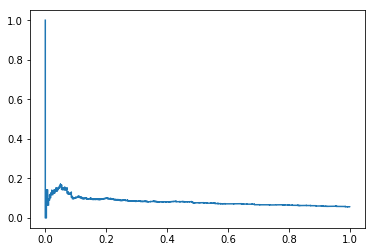

In [156]:
f, axes = plt.subplots()
pred_proba = clf.predict_proba(X_test_new1)
precision, recall, _ = precision_recall_curve(y_test1, pred_proba[:,1])
axes.step(recall, precision)

for j in range(len(recall)):
    if recall[j]<0.5:
        j=j+1
    else:
        precision_Re_50 = precision[j]
print('precision_Re_50'+"  "+ str(precision_Re_50))
print()

In [157]:
# We found that accuracy was very low, so we tried to integrate the classifier using ensemble learning methods.
mark_dict = {}
for i in range(23):
    clf = GaussianNB()
    X_train_new1 = new_feature_train[:,:i+1] # input how many features
    X_val_new1 = new_feature_val[:,:i+1]
    clf.fit(X_train_new1,y_train1)
    bdt = AdaBoostClassifier(clf,n_estimators=50)
    bdt.fit(X_train_new1,y_train1)
    scores1 = bdt.score(X_val_new1, y_val1)
    mark_dict[i+1] = scores1
    print(i+1)
    print(scores1)
    print()
a = sorted(mark_dict.items(), key=lambda x: x[1],reverse = True)
print("When there are {0} features, the accuracy can reach to {1}".format(a[0][0],a[0][1]))

1
0.5241157556270096

2
0.5431160479391991

3
0.5378544285296697

4
0.7383805904706227

5
0.9406606255480854

6
0.05407775504238527

7
0.6544869921075709

8
0.4641917567962584

9
0.45103770827243495

10
0.71821104940076

11
0.6550716164864074

12
0.9541069862613271

13
0.893306050862321

14
0.391406021631102

15
0.6501023092662964

16
0.31949722303420053

17
0.9111370944168372

18
0.9511838643671441

19
0.9330605086232096

20
0.6805027769657995

21
0.17977199649225373

22
0.84536685179772

23
0.3393744519146448

When there are 12 features, the accuracy can reach to 0.9541069862613271


In [163]:
X_test_new1 = new_feature_test[:,:12]
clf = GaussianNB()
X_train_new1 = new_feature_train[:,:12] # input how many features
X_val_new1 = new_feature_val[:,:12]
clf.fit(X_train_new1,y_train1)
bdt = AdaBoostClassifier(clf,n_estimators=50)
bdt.fit(X_train_new1,y_train1)
bdt.score(X_test_new1, y_test1)

0.9437550040032026

precision_Re_50  0.04630541871921182



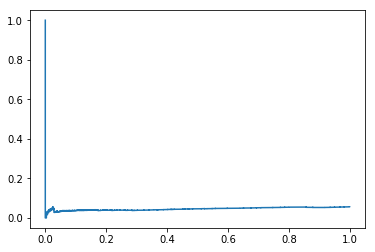

In [164]:
f, axes = plt.subplots()
pred_proba = bdt.predict_proba(X_test_new1)
precision, recall, _ = precision_recall_curve(y_test1, pred_proba[:,1])
axes.step(recall, precision)

for j in range(len(recall)):
    if recall[j]<0.5:
        j=j+1
    else:
        precision_Re_50 = precision[j]
print('precision_Re_50'+"  "+ str(precision_Re_50))
print()

In [174]:
#method 2 decision tree
X_train1 = np.asarray(X_train)
X_val1 = np.asarray(X_val)
X_test1 = np.asarray(X_test)

In [175]:
new_feature_train = X_train1[:,sort_list]
new_feature_val = X_val1[:,sort_list]
new_feature_test = X_test1[:,sort_list]
marks = []
for i in range(23):
    clf = DecisionTreeClassifier()
    X_train_new1 = new_feature_train[:,:i+1] # input how many features
    X_val_new1 = new_feature_val[:,:i+1]
    X_test_new1 = new_feature_test[:,:i+1]
    clf.fit(X_train_new1,y_train1)
    scores = clf.score(X_val_new1, y_val1)
    print(i+1)
    print(scores)
    print()
    marks.append(scores)
print(max(marks))

1
0.5992399883075125

2
0.6126863490207541

3
0.8839520608009354

4
0.8938906752411575

5
0.8994446068401052

6
0.9114294066062555

7
0.904121601870798

8
0.893306050862321

9
0.8982753580824321

10
0.9047062262496346

11
0.9000292312189418

12
0.8979830458930137

13
0.9000292312189418

14
0.9085062847120725

15
0.9047062262496346

16
0.9093832212803273

17
0.9023677287342882

18
0.904121601870798

19
0.904121601870798

20
0.9055831628178895

21
0.9032446653025431

22
0.904121601870798

23
0.9067524115755627

0.9114294066062555


In [182]:
clf = DecisionTreeClassifier()
X_train_new1 = new_feature_train[:,:6] # input how many features
X_val_new1 = new_feature_val[:,:6]
X_test_new1 = new_feature_test[:,:6]
clf.fit(X_train_new1,y_train1)
scores = clf.score(X_test_new1, y_test1)
scores

0.8863090472377902

precision_Re_50  0.056244995996797435



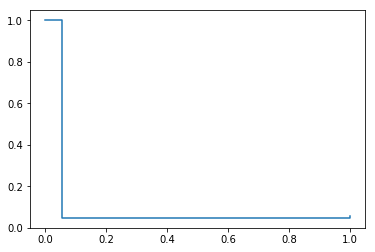

In [183]:
f, axes = plt.subplots()
pred_proba = clf.predict_proba(X_test_new1)
precision, recall, _ = precision_recall_curve(y_test1, pred_proba[:,1])
axes.step(recall, precision)

for j in range(len(recall)):
    if recall[j]<0.5:
        j=j+1
    else:
        precision_Re_50 = precision[j]
print('precision_Re_50'+"  "+ str(precision_Re_50))
print()

In [184]:
# We found that accuracy was very low, so we tried to integrate the classifier using ensemble learning methods.
mark_dict = {}
for i in range(23):
    clf = DecisionTreeClassifier()
    X_train_new1 = new_feature_train[:,:i+1] # input how many features
    X_val_new1 = new_feature_val[:,:i+1]
    clf.fit(X_train_new1,y_train1)
    bdt = AdaBoostClassifier(clf,n_estimators=50)
    bdt.fit(X_train_new1,y_train1)
    scores1 = bdt.score(X_val_new1, y_val1)
    mark_dict[i+1] = scores1
    print(i+1)
    print(scores1)
    print()
a = sorted(mark_dict.items(), key=lambda x: x[1],reverse = True)
print("When there are {0} features, the accuracy can reach to {1}".format(a[0][0],a[0][1]))

1
0.5992399883075125

2
0.6135632855890091

3
0.9032446653025431

4
0.9260450160771704

5
0.8971061093247589

6
0.9117217187956738

7
0.904121601870798

8
0.8918444899152295

9
0.8994446068401052

10
0.9044139140602163

11
0.9003215434083601

12
0.9006138555977784

13
0.9003215434083601

14
0.9061677871967261

15
0.9029523531131248

16
0.9076293481438176

17
0.9038292896813798

18
0.9035369774919614

19
0.9038292896813798

20
0.9044139140602163

21
0.9011984799766151

22
0.9049985384390529

23
0.9035369774919614

When there are 4 features, the accuracy can reach to 0.9260450160771704


In [185]:
X_test_new1 = new_feature_test[:,:4]
X_train_new1 = new_feature_train[:,:4] # input how many features
X_val_new1 = new_feature_val[:,:4]
clf = DecisionTreeClassifier()
clf.fit(X_train_new1,y_train1)
bdt = AdaBoostClassifier(clf,n_estimators=50)
bdt.fit(X_train_new1,y_train1)
bdt.score(X_test_new1, y_test1)

0.9129303442754203

precision_Re_50  0.05776321179844326



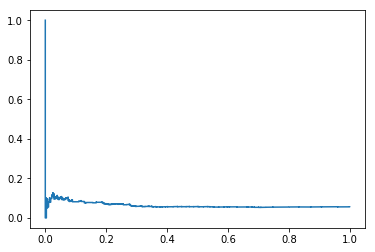

In [186]:
f, axes = plt.subplots()
pred_proba = bdt.predict_proba(X_test_new1)
precision, recall, _ = precision_recall_curve(y_test1, pred_proba[:,1])
axes.step(recall, precision)

for j in range(len(recall)):
    if recall[j]<0.5:
        j=j+1
    else:
        precision_Re_50 = precision[j]
print('precision_Re_50'+"  "+ str(precision_Re_50))
print()